## Read file

In [16]:
import numpy as np
import pandas as pd

class ProductionData:
    def __init__(self, demand_forecast, setup_cost, production_cost, holding_cost, num_periods):
        self.demand_forecast = np.array(demand_forecast)
        self.setup_cost = np.array(setup_cost)
        self.production_cost = np.array(production_cost)
        self.holding_cost = np.array(holding_cost)
        self.num_periods = num_periods
    
    def __repr__(self):
        return (f"ProductionData(\n"
                f"  Demand Forecast: {self.demand_forecast}\n"
                f"  Setup Cost: {self.setup_cost}\n"
                f"  Production Cost: {self.production_cost}\n"
                f"  Holding Cost: {self.holding_cost}\n"
                f"  Number of Periods: {self.num_periods}\n")

def read_production_data(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Insert dummy period 0
    demand_forecast = np.insert(df["Demand Forecast"].to_numpy(), 0, 0)
    setup_cost = np.insert(df["Setup Cost"].to_numpy(), 0, 0)
    production_cost = np.insert(df["Production cost"].to_numpy(), 0, 0)
    holding_cost = np.insert(df["Holding cost"].to_numpy(), 0, 0)
    
    num_periods = df.shape[0]
    
    return ProductionData(demand_forecast, setup_cost, production_cost, holding_cost, num_periods)

# Define file path and sheet names
file_path = "ULSP-instancesR.xlsx"
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]



## 1 MILP AND LP solutions (Gurobi)

### 1.1 MILP

In [17]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np


# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S"])

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    T=data.num_periods
    
    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  

    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")

    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")

    # Solve model
    model.optimize()

    if model.status == GRB.OPTIMAL:

        print(f"{'Period':<10}{'y':<10}{'x':<10}{'S':<15}")
        for t in range(1, T+1):
            y_val = y[t].X
            x_val = x[t].X
            S_val = S[t].X

            # Print results for the current period
            print(f"{t:<10}{y_val:<10}{x_val:<15}{S_val:<15}")

            # Append to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [y_val],
                "x": [x_val],
                "S": [S_val]
            })], ignore_index=True)
        
        
# Print all results at the end
print("\nAll results:")
print(results_df)

# Optionally save to a CSV file
results_df.to_csv("non_optimized_results.csv", index=False)
print("\nResults saved to 'val_results.csv'.")



Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0x0695a2d9
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 7 rows and 10 columns
Presolve time: 0.00s
Presolved: 7 rows, 11 columns, 17 nonzeros
Variable types: 7 continuous, 4 integer (4 binary)
Found heuristic solution: objective 58264.000000

Root relaxation: objective 5.487500e+04, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objec

C:\Users\irako\AppData\Local\Temp\ipykernel_15192\2379512754.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({



CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 26 rows, 39 columns and 62 nonzeros
Model fingerprint: 0x9a0ebf4f
Variable types: 26 continuous, 13 integer (13 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Found heuristic solution: objective 60593.000000
Presolve removed 7 rows and 9 columns
Presolve time: 0.00s
Presolved: 19 rows, 30 columns, 48 nonzeros
Variable types: 19 continuous, 11 integer (11 binary)

Root relaxation: objective 4.210245e+04, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

   

### 2. LP-Relaxation vs MILP solutions

In [18]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import time

# Function to solve ULSP for LP relaxation and MILP
def solve_ulsp(data, relax_y=False):
    T = data.num_periods
    model = gp.Model("ULSP")
    
    # Decision variables
    y = model.addVars(T+1, vtype=GRB.CONTINUOUS if relax_y else GRB.BINARY, lb=0, ub=1, name="y")
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    
    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )
    
    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")
    
    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")
    
    # Solve model
    start_time = time.time()
    model.optimize()
    solve_time = time.time() - start_time
    
    # Store results
    obj_value = model.objVal if model.status == GRB.OPTIMAL else None
    return obj_value, solve_time, model

# Data storage
results = []

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")
    
    # Read data
    data = read_production_data(file_path, sheet_name)
    
    # Solve LP relaxation
    lp_obj, lp_time, lp_model = solve_ulsp(data, relax_y=True)
    
    # Solve MILP
    milp_obj, milp_time, milp_model = solve_ulsp(data, relax_y=False)
    
    # Store results
    results.append([sheet_name, lp_obj, lp_time, milp_obj, milp_time])
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Sheet", "LP Objective", "LP Time", "MILP Objective", "MILP Time"])

# Print and save results
print("\nFinal Results:")
print(results_df)
results_df.to_csv("lp_vs_milp_nobacklog_results.csv", index=False)
print("Results saved to 'lp_vs_milp_results.csv'.")



Processing sheet: 6-periods (1)
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0xdf62efda
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 11 rows and 14 columns
Presolve time: 0.01s
Presolved: 3 rows, 7 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9136788e+04   5.367251e+01   0.000000e+00      0s
Extra simplex iterations after uncrush: 3
       6    5.1762337e+04   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds (0.00 work

## 3.1 Pattern Observation in MILP

The first observation is that the Setups are minimized by clustering them together(at-least for the selected instances), as the model aims to reduce the frequency of costly setups(setup costs are really high), leading to grouped production that satisfies future demand while keeping inventory costs low. This patterns—setup minimization is fundamental to achieving optimal solutions in this problem, ensuring that the model always finds an efficient balance between setup costs, production costs, and inventory holding costs.

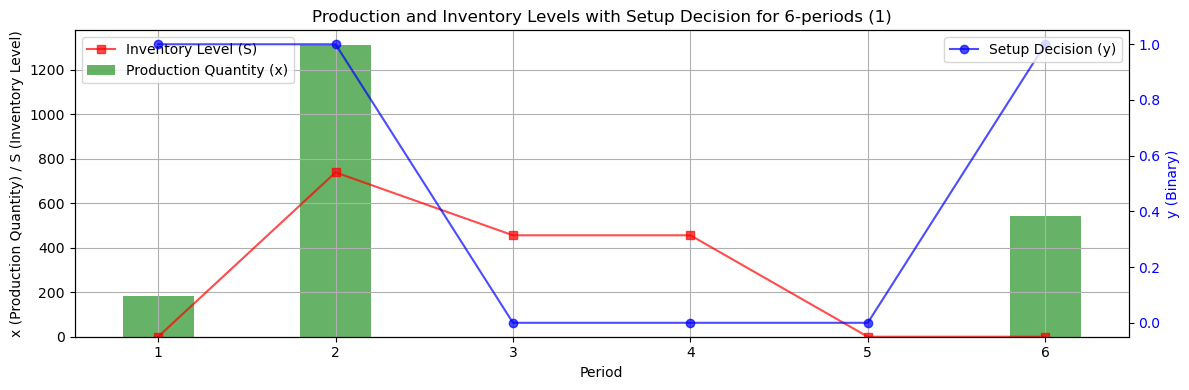

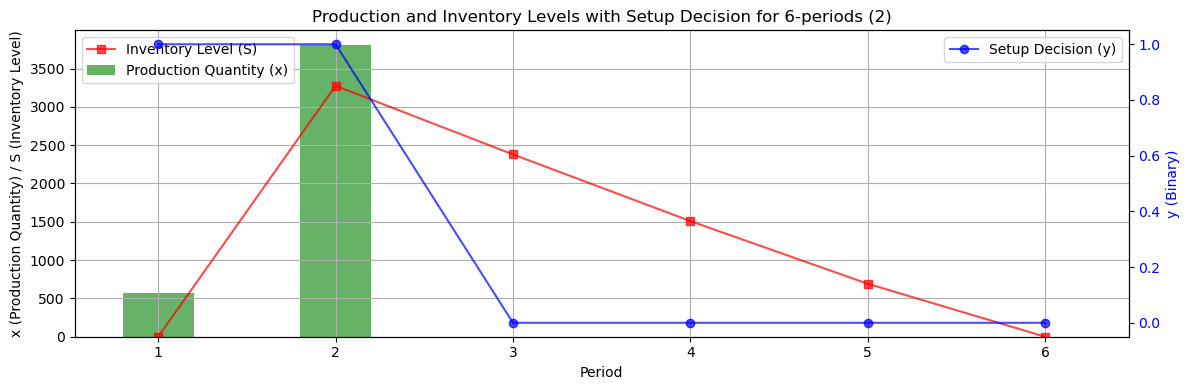

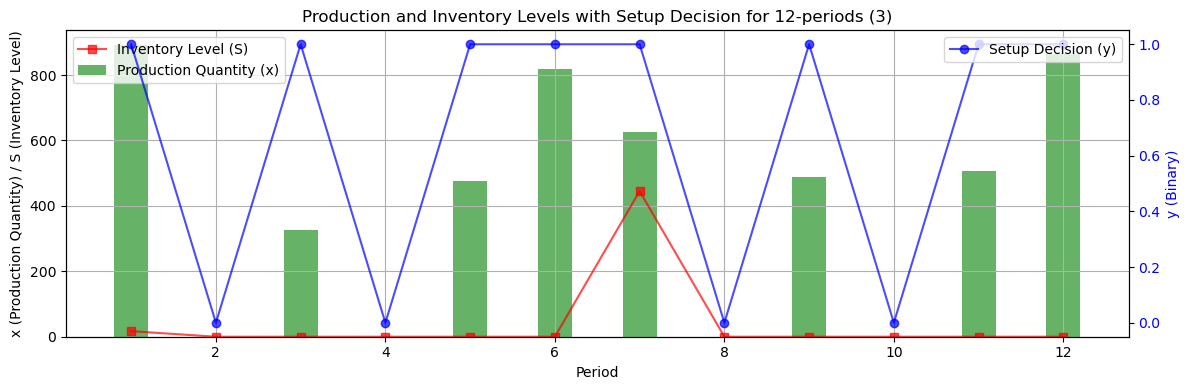

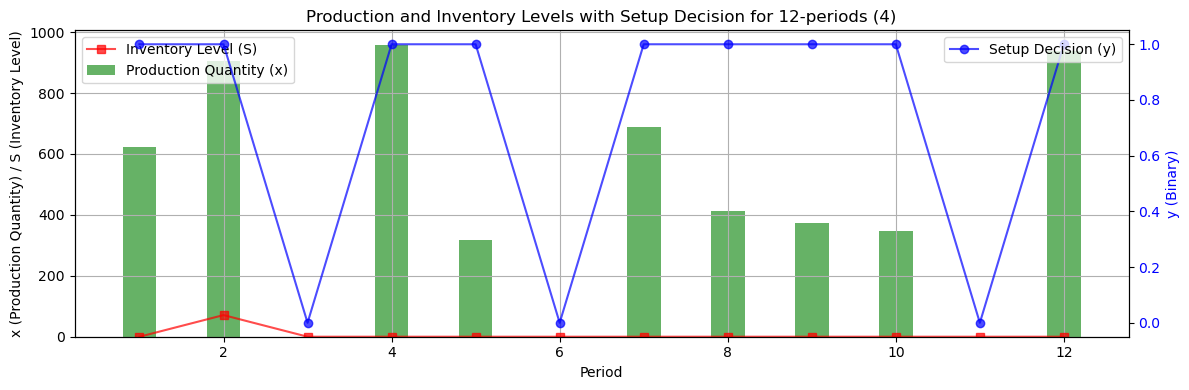

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the all_results CSV file into a DataFrame
results_df = pd.read_csv("non_optimized_results.csv")

# Define function to plot data
def plot_data(data, sheet_name):
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    ax1.bar(data['Period'], data['x'], color='g', width=0.4, label='Production Quantity (x)', alpha=0.6)
    ax1.plot(data['Period'], data['S'], marker='s', linestyle='-', color='r', label='Inventory Level (S)', alpha=0.7)
    ax1.set_xlabel('Period')
    ax1.set_ylabel('x (Production Quantity) / S (Inventory Level)')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.plot(data['Period'], data['y'], marker='o', linestyle='-', color='b', label='Setup Decision (y)', alpha=0.7)
    ax2.set_ylabel('y (Binary)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    plt.title(f'Production and Inventory Levels with Setup Decision for {sheet_name}')
    ax1.grid(True)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# spliting the CSV into instances
sheet_ranges = [
    ("6-periods (1)", 0, 6),
    ("6-periods (2)", 6, 12),
    ("12-periods (3)", 12, 24),
    ("12-periods (4)", 24, 36)
]

for sheet_name, start_row, end_row in sheet_ranges:
    sheet_data = results_df.iloc[start_row:end_row] 
    plot_data(sheet_data, sheet_name)

## 3.2 Wagner within

In [20]:
import numpy as np

def wagner_whitin_nobacklog(demand, setup_costs, holding_costs, unit_costs, num_periods):
    T = num_periods  # Number of periods
    C = np.full(T+1, float('inf'))  # Cost array, initialized to infinity
    C[0] = 0  # Base case: No cost at period 0
    order_periods = [-1] * (T+1)  # To track order placements
    
    # For each period t
    for t in range(1, T+1):
        # Try all possible last order periods j to find which j to produce to meed the demand
        for j in range(1, t+1): # 
            # Calculate costs when producing in period j for periods j through t
            
            # Setup cost for production in period j
            cost = setup_costs[j]
            
            # Production cost for all demand from j to t
            production_cost = unit_costs[j] * sum(demand[k] for k in range(j, t+1))
            cost += production_cost
            
            # Holding costs for demands of periods k (j < k ≤ t)
            holding_cost = sum(
                holding_costs[k] * sum(demand[m] for m in range(k+1, t+1))
                for k in range(j, t)
            )
            cost += holding_cost
            
            # Add cost of optimal solution up to j-1
            total_cost = C[j-1] + cost
            
            # Update if this solution is better (minimum cost for j period)
            if total_cost < C[t]:
                C[t] = total_cost
                order_periods[t] = j
    
    # Backtrack to find optimal order schedule
    t = T
    orders = []
    while t > 0:
        j = order_periods[t]
        order_quantity = sum(demand[k] for k in range(j, t+1))
        orders.append((j, order_quantity))
        t = j-1
    
    return list(reversed(orders)), C[T]
    
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    #print(data.demand_forecast[0])
    #print(data.holding_cost[0])

    optimal_orders, min_cost = wagner_whitin_nobacklog(data.demand_forecast, data.setup_cost, data.holding_cost, data.production_cost, data.num_periods)
    print("Optimal order schedule:", optimal_orders)
    print("Minimum total cost:", min_cost)





Processing sheet: 6-periods (1)
Optimal order schedule: [(1, 185), (2, 1312), (6, 542)]
Minimum total cost: 54875.0

Processing sheet: 6-periods (2)
Optimal order schedule: [(1, 573), (2, 3808)]
Minimum total cost: 105079.0

Processing sheet: 12-periods (1)
Optimal order schedule: [(1, 892), (3, 325), (5, 477), (6, 817), (7, 627), (9, 487), (11, 506), (12, 863)]
Minimum total cost: 54291.0

Processing sheet: 12-periods (2)
Optimal order schedule: [(1, 623), (2, 906), (4, 958), (5, 319), (7, 689), (8, 414), (9, 372), (10, 346), (12, 938)]
Minimum total cost: 44793.0

Processing sheet: 24-periods (1)
Optimal order schedule: [(1, 660), (2, 837), (3, 164), (5, 857), (6, 190), (9, 100), (10, 454), (11, 924), (12, 496), (13, 703), (14, 469), (15, 706), (16, 907), (17, 321), (19, 192), (22, 883), (23, 783), (24, 727)]
Minimum total cost: 78316.0

Processing sheet: 24-periods (2)
Optimal order schedule: [(1, 1067), (3, 1366), (5, 853), (7, 695), (11, 842), (13, 1245), (16, 958), (18, 585), (1

## 4. Verify inequalities

In [21]:

# Read the Excel file from the specific sheet
data=read_production_data(file_path,"6-periods (1)" )
T=data.num_periods
    
# Create Gurobi model
model = gp.Model("Uncapacitated Lot-Sizing Problem")

# Decision variables as before ofc 
y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  

# Objective function
model.setObjective(
    quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
    quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
    quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
    GRB.MINIMIZE
)

# Constraints
model.addConstr(S[0] == 0, name="no_inventory0")
model.addConstr(S[T] == 0, name="no_inventoryT")

for t in range(1, T+1):
    model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t])
    model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t])

#in this case we don't care about previous objective function, we care about checking validity of new ineq for all the variables in the polyhedron
# Define l and S for the inequality check
l = T  # Last period (you can change this dynamically)
S_subset = list(range(1, l+1))  # Example subset

# Compute D_tl values, l is fixed, tehre is a D_tl for each t, looks like it's a matrix
D = [[0] * (T+1) for x in range(T+1)] 
for l_val in range(1, T+1):  # Loop over l
    for t in range(1, l_val+1):  # Loop over t from 1 to l
        D[t][l_val] = sum(data.demand_forecast[i] for i in range(t, l_val+1))

#all constrints set

model.setParam(GRB.Param.PoolSearchMode, 2)  # Explore entire feasible region
model.setParam(GRB.Param.PoolSolutions, 10000000)  # Allow up to 1M solutions (adjust if needed)

model.optimize()

num_solutions = model.SolCount  # Get the number of feasible solutions found
print(f"Total feasible integer solutions found: {num_solutions}")


model.optimize()

print(model.solcount)


integer_solutions = []
for i in range(model.SolCount):
    model.setParam(GRB.Param.SolutionNumber, i)
    y_values = model.getAttr("Xn", y)

    # Check if all y-values are integer
    if all(abs(y_values[t] - round(y_values[t])) < 1e-6 for t in range(1, T+1)):
        integer_solutions.append(y_values)
# Iterate through the feasible solutions Gurobi found

N=len(integer_solutions)


# Verify the inequality for all integer solutions
for i in range(N):  
    y_values = integer_solutions[i]  # Directly use stored values

    # Extract x and S values
    x_values = model.getAttr("X", x)  
    S_values = model.getAttr("X", S)  

    # Compute left-hand and right-hand side for the inequality
    for l_val in range(1, T+1):
        lhs = sum(x_values[t] for t in range(1, l_val+1))
        rhs = sum(D[t][l_val] * y_values[t] for t in range(1, l_val+1)) + S_values[l_val]
        
        if lhs > rhs:
            print(f" Inequality violated at solution {i}: {lhs} > {rhs}")
            break  # Stop checking if one violation is found          
            
print("valid inequalities")
    
    

Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 10000000
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
PoolSolutions  10000000
PoolSearchMode  2

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0x0695a2d9
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 8 rows, 15 columns, 20 nonzeros
Variable types: 9 continuous, 6 integer (6 binary)
Found heuristic solution: objective 60397.000000

Root relaxati

## 5. Separation technique

In [22]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np

# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "y", "x", "S"])


sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)"]


# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")
    
    # Read the Excel file from the specific sheet
    data = read_production_data(file_path, sheet_name)
    T = data.num_periods
    
    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")
    
    # Decision variables
    y = model.addVars(T+1, vtype=GRB.BINARY, name="y")  
    x = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="x")  
    S = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, name="S")  
    
    # Objective function
    model.setObjective(
        quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +
        quicksum(data.production_cost[t] * x[t] for t in range(1, T+1)) +
        quicksum(data.holding_cost[t] * S[t] for t in range(1, T+1)),
        GRB.MINIMIZE
    )

    # Constraints
    model.addConstr(S[0] == 0, name="no_inventory0")
    model.addConstr(S[T] == 0, name="no_inventoryT")

    # Relax binary constraints on y to be continuous in [0,1]
    for t in range(1, T+1):
        y[t].vtype = GRB.CONTINUOUS  # Convert binary to continuous
        y[t].lb = 0  # Lower bound
        y[t].ub = 1  # Upper bound


    for t in range(1, T+1):
        model.addConstr(x[t] + S[t-1] == data.demand_forecast[t] + S[t], name=f"demand_satisfied_{t}")
        model.addConstr(x[t] <= quicksum(data.demand_forecast[m] for m in range(t, T+1)) * y[t], name=f"setup_constraint_{t}")

    # Solve initial LP relaxation
    model.Params.InfUnbdInfo = 1  # Ensure feasibility insights
    model.optimize()
    # Retrieve LP-relaxed solution
    x_vals = {t: x[t].X for t in range(1, T+1)}
    y_vals = {t: y[t].X for t in range(1, T+1)}
    S_vals = {t: S[t].X for t in range(1, T+1)}
    
    # Print LP relaxation results
    print("\nLP Relaxation Solution:")
    for t in range(1, T+1):
        print(f"Period {t}: y={y_vals[t]:.4f}, x={x_vals[t]:.4f}, S={S_vals[t]:.4f}")

    while True:
        # Get LP relaxation solution, yeah
        x_vals = {t: x[t].X for t in range(1, T+1)}
        y_vals = {t: y[t].X for t in range(1, T+1)}
        S_vals = {t: S[t].X for t in range(1, T+1)}

        # Separation procedure: Find the most violated (l, S) inequality
        most_violated = None
        max_violation = 0
        
        for l in range(1, T+1): #for each subset, we are finding the most violated
            
            S_l = [j for j in range(1, l+1) if x_vals[j] - sum(data.demand_forecast[j:l+1]) * y_vals[j] > 0]
            
            if not S_l:
                continue
            
            v_l = sum(x_vals[t] - sum(data.demand_forecast[t:l+1]) * y_vals[t] for t in S_l) - S_vals[l]
            
            if v_l > max_violation:
                max_violation = v_l
                most_violated = (l, S_l)

        # If no violated inequalities, stop
        if max_violation <= 0:
            break
        
        # Add the most violated (l, S) inequality
        l_star, S_star = most_violated
        model.addConstr(quicksum(x[t] for t in S_star) <= quicksum(data.demand_forecast[t] * y[t] for t in S_star) + S[l_star], name=f"(l,S)_ineq_{l_star}")
        
        # Re-optimize with new constraints
        model.optimize()
    
    # Store final results
    if model.status == GRB.OPTIMAL:
        for t in range(1, T+1):
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [y[t].X],
                "x": [x[t].X],
                "S": [S[t].X]
            })], ignore_index=True)

# Print results
print("\nAll results:")
print(results_df)

# Save results
results_df.to_csv("separation_results.csv", index=False)
print("\nResults saved to 'all_results.csv'.")    


Processing sheet: 6-periods (1)
Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
InfUnbdInfo  1

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 14 rows, 21 columns and 32 nonzeros
Model fingerprint: 0xe3ce65a0
Variable types: 20 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 14 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 51762.3 51762.3 



C:\Users\irako\AppData\Local\Temp\ipykernel_15192\3887583346.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
InfUnbdInfo  1

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 26 rows, 39 columns and 62 nonzeros
Model fingerprint: 0x96c459bb
Variable types: 38 continuous, 1 integer (1 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Presolve removed 26 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 40404.2 40404.2 

Optimal solution found (tolerance

## 7. Facility location reformulation (FLPR).

Now, define the variable wqt to be the amount produced in period q (q <= t) and used to meet the 
demand of the item in period t; that is the fraction of the demand of the item in period t that is 
produced in period q. Reformulate the single-item uncapacitated lot-sizing problem using only wqt and 
yt variables. This reformulation is called the facility location reformulation (FLPR)


I produce in q to satisfy in period t

demand of period t can be satisfied by different periods q


### LOOKS LIKE THE PRODUCTION QUANTITIES DO NOT CHANGE

In [23]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
from pydantic import constr


# DataFrame to store all results
results_df = pd.DataFrame(columns=["Sheet", "Period", "w", "y",])

sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)"]

# Process each sheet
for sheet_name in sheet_list:
    print(f"\nProcessing sheet: {sheet_name}")

    # Read the Excel file from the specific sheet
    data=read_production_data(file_path, sheet_name)
    T=data.num_periods
    print(T)

    M = sum(data.demand_forecast) #consatnt for contraint 2

    # Create Gurobi model
    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    # Decision variables
    y = model.addVars(T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y")  
    w = model.addVars(T+1, T+1, vtype=GRB.CONTINUOUS, name="w")

    
    #in period t i have invetory cost equal to the cost of inv in this period*(what i produced in precedent period to satisfy demand in period from t+1 to T)
    # Objective function
    model.setObjective(
    quicksum(data.setup_cost[t] * y[t] for t in range(1, T+1)) +  # Setup costs
    quicksum(quicksum(data.production_cost[q] * w[q, t] for t in range(q, T+1)) for q in range(1, T+1)) +  # Production costs
    quicksum(  # Holding costs
        quicksum(
            data.holding_cost[t] * quicksum(w[q, f] for f in range(t+1, T+1))
            for q in range(1, t+1)
        ) for t in range(1, T)
    ),
    GRB.MINIMIZE
    ) ###check obj again but should be it

    # Constraints, we don't have backlogging, must satisfy demand for each period immediately
    for t in range( 1, T+1):
        model.addConstr((quicksum( w[q, t] for q in range( 1, t+1) ) ) == data.demand_forecast[t])

    #ok miss a contraint for the y, need it to be one when we produce
    for q in range(1, T+1):
        model.addConstr((quicksum(w[q, t] for t in range(q, T+1))<= M*y[q]))


    # Solve model
    model.optimize()

    # Store results in DataFrame
    if model.status == GRB.OPTIMAL:

        print(f"{'Period':<10}{'y':<30}{'w':<10}")
        for t in range(1, T+1):
            y_val = y[t].X
            w_val = sum(w[t,q].X for q in range (t, T+1))

            # Print results for the current period
            print(f"{t:<10}{y_val:<30}{w_val:<15}")

            # Append to DataFrame
            results_df = pd.concat([results_df, pd.DataFrame({
                "Sheet": [sheet_name],
                "Period": [t],
                "y": [y_val],
                "w": [w_val]
                
            })], ignore_index=True)
        
        
# Print all results at the end
print("\nAll results:")
print(results_df)

# Print and save results
results_df.to_csv("FLPR_results.csv", index=False)
print("\nResults saved to 'all_results.csv'.")



Processing sheet: 6-periods (1)
6
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 12 rows, 56 columns and 48 nonzeros
Model fingerprint: 0x82b96955
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [8e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
Presolve removed 5 rows and 42 columns
Presolve time: 0.01s
Presolved: 7 rows, 14 columns, 23 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7648807e+04   4.106950e+01   0.000000e+00      0s
       2    5.0467398e+04   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.046739823e

C:\Users\irako\AppData\Local\Temp\ipykernel_15192\2684561619.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


12
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2560044 - for non-commercial use only - registered to vi___@ugent.be
Optimize a model with 24 rows, 182 columns and 168 nonzeros
Model fingerprint: 0xe6efa56d
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [5e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 9e+02]
Presolve removed 6 rows and 121 columns
Presolve time: 0.01s
Presolved: 18 rows, 61 columns, 111 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6245124e+04   5.096670e+01   0.000000e+00      0s
       9    3.8015598e+04   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.801559812e+04
Period    y            